# Backprop from outputs

The plan:
1. backprop from task outputs to each layer to generate activation space gradients
1. apply PCA to these gradients (as we have done above)
1. we will then have two sets of components, one for each task for every set of activations (I suppose all the way back to the individual inputs)
1. compare these two sets of components and test for orthogonality (at least in the highest variance components for each task).

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 1322468781
set_all_seeds(seed)
print(seed)

1472495906


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


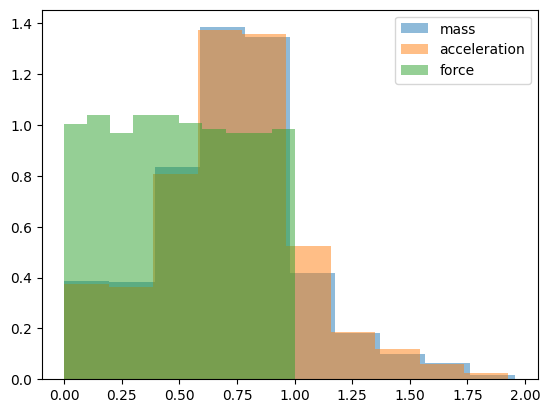

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

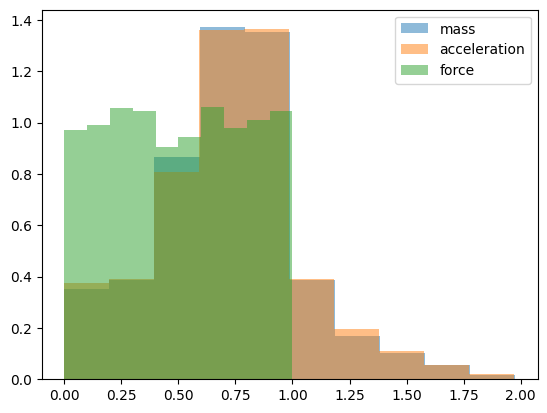

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

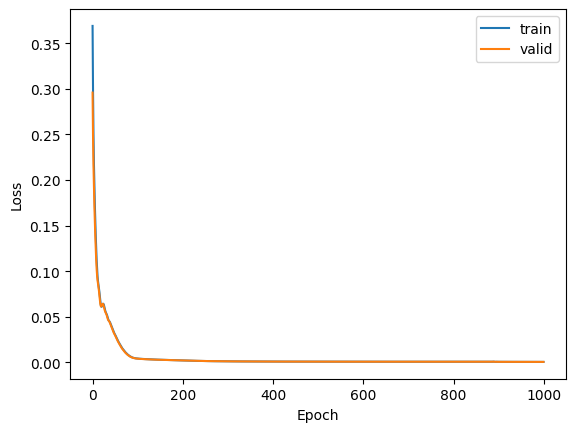

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0005)

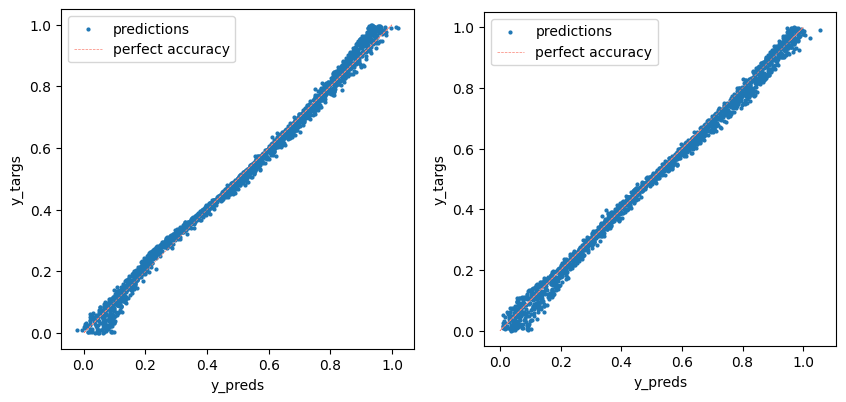

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [14]:
from physics_mi.analysis import capture_intermediate_outputs

In [15]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [16]:
task_inputs = torch.cat(
    (get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B"))
)
task_inputs.shape

torch.Size([20000, 4])

In [17]:
valid_ios = capture_intermediate_outputs(model, X_valid)
task_ios = capture_intermediate_outputs(model, task_inputs)

Now we'd like to compare the principal components at `layers.0.act` with those from `layers.1.act` I think.

In [18]:
def get_pcs(data):
    mean = torch.mean(data, 0)
    data_centered = data - mean

    # Step 2: Compute the SVD
    U, S, V = torch.svd(data_centered)

    # The columns of V are the principal components
    principal_components = V

    # Step 3: Compute variances
    variances = S.pow(2) / (data.size(0) - 1)

    return principal_components, variances

In [19]:
task_acts = {}
task_acts["0"] = task_ios["layers.0.act"]
task_acts["1"] = task_ios["layers.1.act"]
task_acts["0"].shape, task_acts["1"].shape

(torch.Size([20000, 16]), torch.Size([20000, 16]))

In [20]:
valid_acts = {}
valid_acts["0"] = valid_ios["layers.0.act"]
valid_acts["1"] = valid_ios["layers.1.act"]
valid_acts["0"].shape, valid_acts["1"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [21]:
valid_pcs = {}
valid_vars = {}
valid_pcs["0"], valid_vars["0"] = get_pcs(valid_acts["0"])
valid_pcs["1"], valid_vars["1"] = get_pcs(valid_acts["1"])
valid_pcs["0"].shape, valid_pcs["1"].shape

(torch.Size([16, 16]), torch.Size([16, 16]))

In [22]:
def get_pc_acts(pcs, acts):
    pc_acts = (pcs.T[None, :] * acts[:, None, :]).sum(-1)
    return pc_acts

In [23]:
valid_pc_acts = {}
valid_pc_acts["0"] = get_pc_acts(valid_pcs["0"], valid_acts["0"])
valid_pc_acts["1"] = get_pc_acts(valid_pcs["1"], valid_acts["1"])
valid_pc_acts["0"].shape, valid_pc_acts["1"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [24]:
valid_ios["layers.0.act"].shape, valid_ios["layers.1.act"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [25]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=4, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=16, bias=True)
      (act): ReLU()
    )
    (2): LinearLayer(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

Now the scaffold net needs to allow me to backprop from the final output to every intermediate layer's activations (and the input as a sanity check). In this case that would be:
- layer1
- layer0
- input

Question is, do I engineer something elegant that extends to any depth architecture, or do I just do this manually for now? 🤔

The elegant solution could include an argument to the forward method that selects the layer to inspect. There's a question of whether the input would be stored as it has been in the class or whether this time it would be simpler to store it externally (as there are now multiple inputs). I think the latter is best.

In [26]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx:]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet()
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [27]:
grads = {}
tasks = ["A", "B"]
for i, task in enumerate(tasks):
    linputs = valid_ios["layers.0.act"].clone().requires_grad_(True)
    out = scaffold_model(1, linputs)
    loss = out[:, i].mean()
    loss.backward()
    grads[task] = {}
    grads[task]["gradients"] = linputs.grad.clone().detach()

for task, _ in grads.items():
    grads[task]["pcs"], grads[task]["vars"] = get_pcs(grads[task]["gradients"])

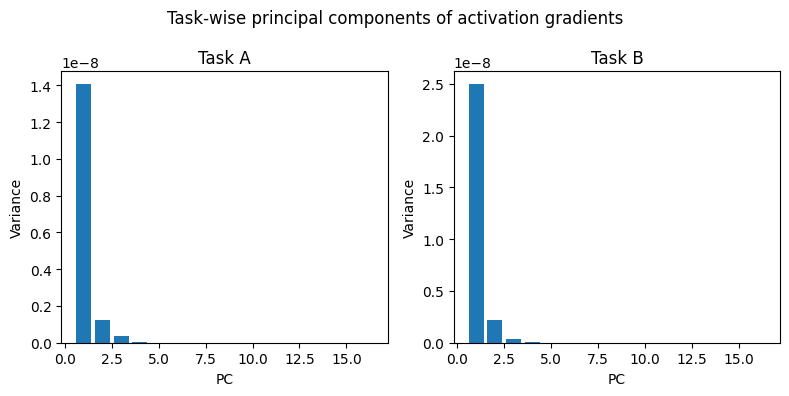

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for ax, task in zip(axes, ("A", "B")):
    ax.bar(range(1, 17), grads[task]["vars"])
    ax.set_title(f"Task {task}")
    ax.set_xlabel("PC")
    ax.set_ylabel("Variance")

fig.suptitle("Task-wise principal components of activation gradients")
fig.set_tight_layout("tight")

The mean is crude but it could be informative:

In [29]:
meanA = grads["A"]["gradients"].mean(0)
meanB = grads["B"]["gradients"].mean(0)
meanA = meanA / meanA.norm()
meanB = meanB / meanB.norm()

torch.dot(meanA, meanB)

tensor(-0.0208)

In [30]:
sims = torch.einsum("ij,ik->jk", grads["A"]["pcs"], grads["B"]["pcs"]).numpy()

In [31]:
def plot_similarity(sims, title="Dot-product Similarity", x_label=None):
    fig, ax = plt.subplots(figsize=(6, 6))

    im = ax.imshow(sims, cmap="bwr", vmin=-1, vmax=1)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=14)

    ax.set_title(title, fontsize=16)

    # I'm pretty sure this is the right way round from ij,ik->jk?
    ax.set_xlabel("Task B PCA", fontsize=14)
    ax.set_ylabel("Task A PCA", fontsize=14)

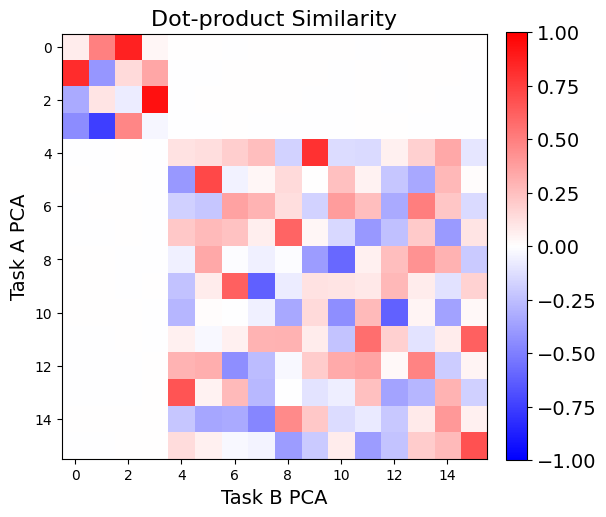

In [32]:
plot_similarity(sims, title="Dot-product Similarity")

#### A thought

Perhaps rather than PCA, we should be using clustering like DBSCAN followed by a mean norm of the gradients in each cluster? The problem with PCA is that it breaks down when we have a large number of almost identical vectors (which we do before the final linear layer).

#### Continuation

So this is promising, we have have low dot products in the TL corner (where all our variance is). Let's use these PCs to know investigate our different tasks.

In [33]:
sliceA = slice(0, 10000)
sliceB = slice(10000, None)

### Task A PCs

I'm first focusing on the gradient PCs extracted from backprop from the task A output and how much variance they explain in both tasks.

In [34]:
task = "A"

Calculating how much variance is explained by these gradient PCs across both task datasets:

In [35]:
grad_pc_acts_A = get_pc_acts(grads[task]["pcs"], task_acts["0"])
varA = grad_pc_acts_A[sliceA].var(0)
varB = grad_pc_acts_A[sliceB].var(0)
varA.shape, varB.shape

(torch.Size([16]), torch.Size([16]))

In [36]:
def plot_pca_variances(varA, varB, grad_pc_variance, err_varA=None, err_varB=None):
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot the variances for Task A and Task B
    ax1.bar(
        range(len(varA)),
        varA,
        yerr=err_varA,
        width=0.4,
        align="center",
        label="Task A activations",
        alpha=0.5,
    )
    ax1.bar(
        range(len(varB)),
        varB,
        yerr=err_varB,
        width=0.4,
        align="center",
        label="Task B activations",
        alpha=0.5,
    )
    ax1.set_xlabel("PCA Component")
    ax1.set_ylabel("Variance")
    ax1.legend(loc="upper left")

    # Create a second y-axis for PC importance
    ax2 = ax1.twinx()
    ax2.scatter(
        range(len(grad_pc_variance)),
        grad_pc_variance,
        label="Gradient PC Variance",
        color="r",
        marker="o",
    )
    ax2.set_ylim(0)
    ax2.set_ylabel("Variance")
    ax2.legend(loc="upper right")

    ax1.set_title(
        "Variance and Gradient PC Variance by each PCA component from task-wise gradients"
    )

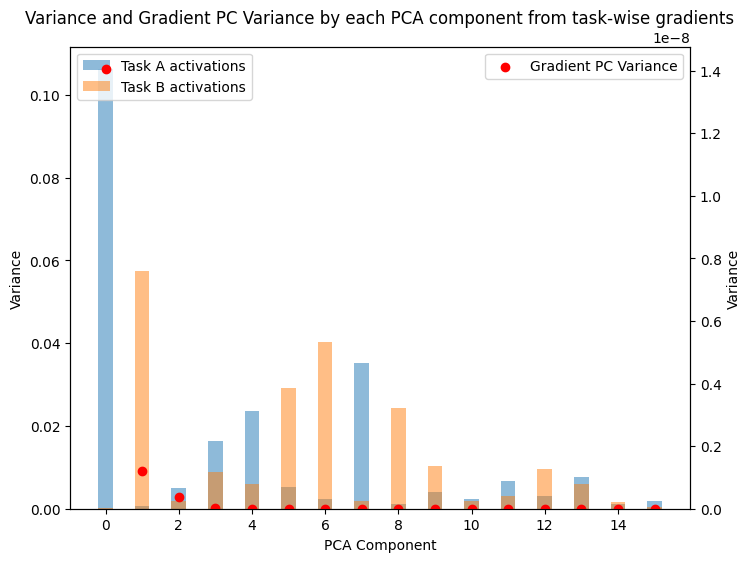

In [37]:
plot_pca_variances(varA, varB, grads[task]["vars"])

### Task B PCs

In [38]:
task = "B"

In [39]:
grad_pc_acts_A = get_pc_acts(grads[task]["pcs"], task_acts["0"])
varA = grad_pc_acts_A[sliceA].var(0)
varB = grad_pc_acts_A[sliceB].var(0)
varA.shape, varB.shape

(torch.Size([16]), torch.Size([16]))

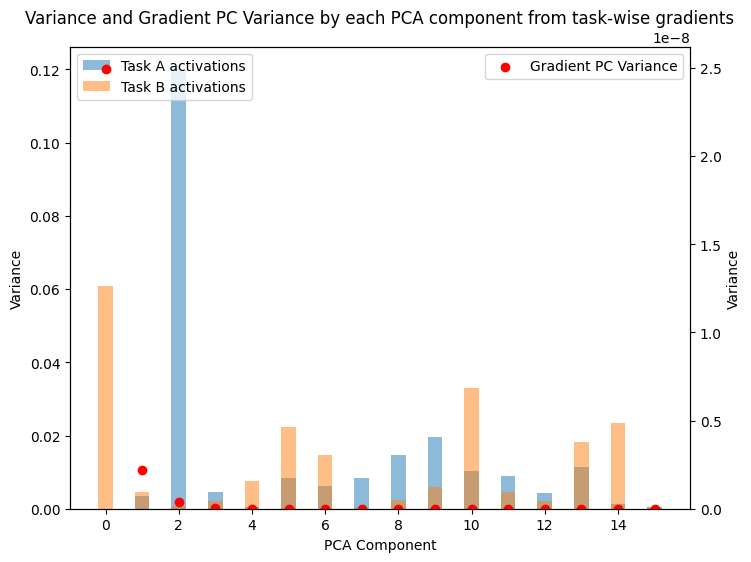

In [40]:
plot_pca_variances(varA, varB, grads[task]["vars"])

## Thoughts

Limitations right now: I've only run this analysis on: 
- _one_ example
- _one_ layer (albeit hidden)

_But_ it's looking really promising.

The plots above aren't so obvious to understand (I think I should sit down and come up with some proper mathematical notation to frame my discussion because it's getting pretty deep here...). However, what they show is very clear task orthogonality in the hidden layer, especially for the components which have the biggest effect on the task in question i.e. have the strongest gradients with respect to that output (which we can read from the red dots).

### Understanding the significance of the PCA variance of the gradients

- This seems to match up pretty well with the task orthogonality
- High variance components in the gradient space are components for which the input data has the most variable impact on the task output. That's to say, sometimes they _do_ have an impact and sometimes they don't.
- This doesn't necessarily feel like the best measure for me? It instead seems to be giving me the components with the most inconsistent impact, I suppose I would like the ones with the _strongest_ impact (i.e. norm)?

## Plan

- Devise some mathematical notation to clearly label all of the quantities I've been plotting
- Do repeats (across multiple model trains)
- Look across all layers (including inputs) - there are three of them

_Then:_
- can start to look at / think about how one could extract the ground truth task-separate components (in this case our output) from a model where we don't have this privileged basis to start with. 
- This might involve understanding how the gradient components relate to the PCA components, or looking at the weight matrices again for clues. 
- Could revisit this idea of training component extractors i.e. train a lightweight model / linear transform to regress the ground truth components and use that or at least use that to help understand whether/how we could extract these components from the weight matrices.

## Better measures of component impact

I get this feeling that whilst the variance of the gradients looks nice on the graphs, it doesn't make sense to me. Let's see if we can get closer to a measure of components with impact.

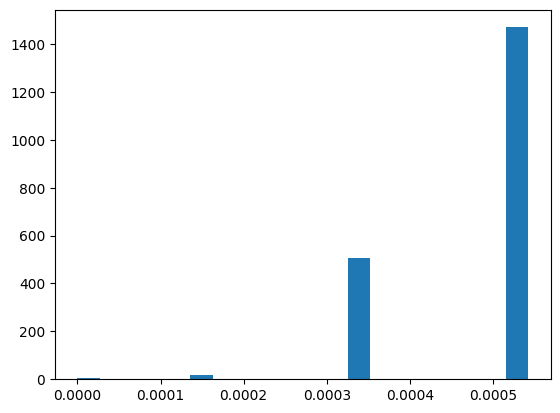

In [41]:
gradients = grads["A"]["gradients"]
pcs = grads["A"]["pcs"]
pc_vars = grads["A"]["vars"]
norms = gradients.norm(dim=1)
scaled_norms = norms
# scaled_norms = (norms - norms.min()) / (norms.max() - norms.min())
_ = plt.hist(scaled_norms, bins=20)

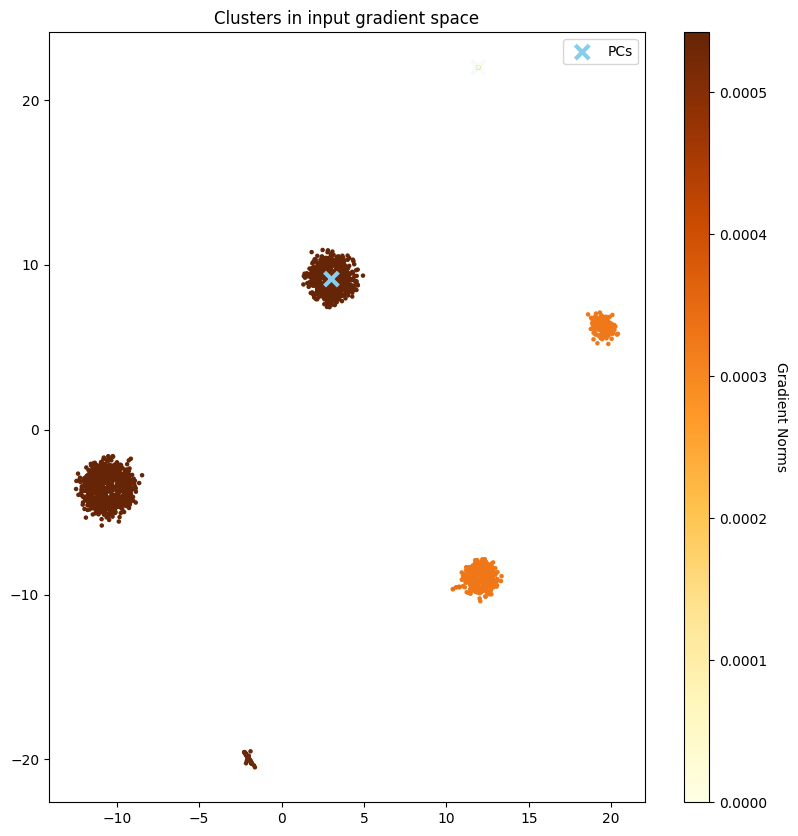

In [42]:
import pacmap
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 10))

embedding = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, save_tree=True
)

# fit the data (The index of transformed data corresponds to the index of the original data)
reduced_data = embedding.fit_transform(gradients.numpy(), init="pca")
reduced_pcs = embedding.transform(pcs.numpy())

norm = mcolors.Normalize(vmin=scaled_norms.min(), vmax=scaled_norms.max())
colors = plt.cm.YlOrBr(norm(scaled_norms))

xy = reduced_data
scatter = ax.scatter(xy[:, 0], xy[:, 1], s=5, alpha=1.0, marker="o", color=colors)

alphas = pc_vars / pc_vars.max()
ax.scatter(
    reduced_pcs[:, 0],
    reduced_pcs[:, 1],
    s=100,
    lw=3,
    alpha=alphas,
    marker="x",
    color="skyblue",
    label="PCs",
)

# Create a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrBr, norm=norm)
cbar = plt.colorbar(sm, ax=ax, aspect=30)
cbar.set_label("Gradient Norms", rotation=270, labelpad=15)

ax.set_aspect("equal")
ax.legend()

_ = ax.set_title("Clusters in input gradient space")

In [ ]:
len(gradients.unique(dim=0))

The important thing to note here is that each cluster is essentially completely homogenous in colour and therefore norm/importance. I suppose the vector space must look a lot like concentric spheres with each cluster lying on the surface of one of the spheres with some angular variance.

#### Observations

- _Sometimes_ the PCs sit on the most important features but quite often they're in tiny little clusters by themselves.
- The number of clusters varies wildly

Should I now try and create components + importances based off of these clusters?

In [43]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans


def get_best_k(data, k_range=(2, 30)):
    # Assuming X is your data
    k_values = range(k_range[0], k_range[1] + 1)
    best_score = -1
    best_k = -1

    for k in tqdm(k_values):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        labels = kmeans.labels_
        score = silhouette_score(data, labels)

        if score > best_score:
            best_score = score
            best_k = k

    return best_k

In [ ]:
best_k = get_best_k(gradients)
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(gradients)
labels = kmeans.labels_
labels = torch.asarray(labels)

In [71]:
centroids = []
norms = []
for label in torch.unique(labels):
    cluster_vectors = gradients[labels == label]
    centroids.append(cluster_vectors.mean(0))
    norm = cluster_vectors.norm(dim=1).mean()
    break

In [72]:
norm

tensor(0.0005)

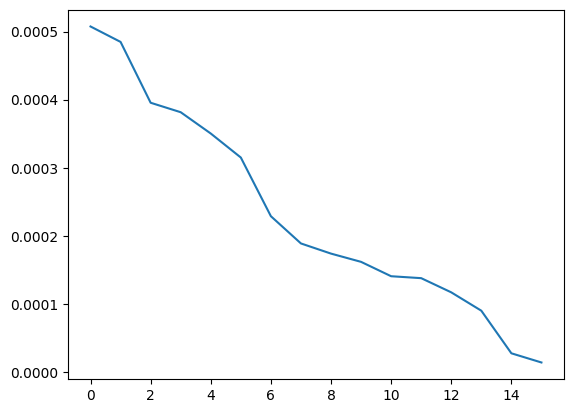

In [97]:
plt.plot(gradients.unique(dim=0).norm(dim=0).sort(descending=True).values)